In [72]:
#Improt libraries for model building and analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold

from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem

import os
import copy

In [73]:
#Load data
data = pd.read_csv("Excape_DB_SLC6A4_active.csv")
data.head(1)

#For building the QSAR model in PyTorch, Im interested in the structure (SMILES format), 
#and the pXC50 which is the – log10 converted IC50 or EC50 values.

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
0,CTETYYAZBPJBHE-UHFFFAOYNA-N,CHEMBL1289,6532,A,6.37,chembl20,774720,9606,SLC6A4,4061,C(#CI)COC=1C=C(Cl)C(=CC1Cl)Cl


,SMILES,Molecule
0,C(#CI)COC=1C=C(Cl)C(=CC1Cl)Cl,
1,C1(=CC=2OCOC2C=C1C)CC(N)C,

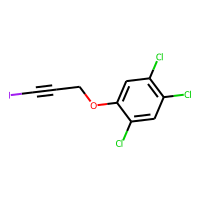
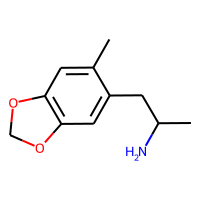

In [74]:
#use RDKit for conversion of the SMILES into molecular objects and for fingerprinting 
#of the molecules. The pandastools module contain convenient functions for creating 
#a molecule column

PandasTools.AddMoleculeColumnToFrame(data,'SMILES','Molecule')
data[["SMILES","Molecule"]].head(2)

In [75]:
#check nan values in the molecule column
data.Molecule.isna().sum()

0

In [76]:
#vectorizing the molecules (embeddings)
def mol2fp(mol):
    fp = AllChem.GetHashedMorganFingerprint(mol, 2, nBits=4096)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar

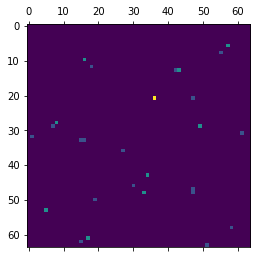

In [77]:
fp =mol2fp(Chem.MolFromSmiles(data.loc[1,"SMILES"]))
plt.matshow(fp.reshape((64,-1)))

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,Molecule,FPs
0,CTETYYAZBPJBHE-UHFFFAOYNA-N,CHEMBL1289,6532,A,6.37,chembl20,774720,9606,SLC6A4,4061,C(#CI)COC=1C=C(Cl)C(=CC1Cl)Cl,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,HCFHWXDIZOAUTQ-UHFFFAOYNA-N,CHEMBL6376,25553,A,6.11,chembl20,201505,10116,SLC6A4,4061,C1(=CC=2OCOC2C=C1C)CC(N)C,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."

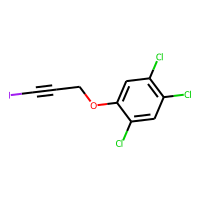
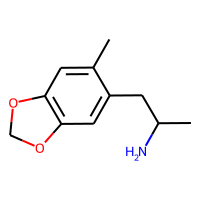

In [78]:
data["FPs"] = data.Molecule.apply(mol2fp)
data.head(2)

In [79]:
X = np.stack(data.FPs.values)
print(X.shape)

(4441, 4096)


In [80]:
#pxC50 data
y = data.pXC50.values.reshape((-1,1))

#split train, val, test
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.10, random_state=1111)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.05, random_state=1111)

#normalise data
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

In [81]:
#if a feature is constant (i.e. it has 0 variance), 
#then it cannot be used for finding any interesting 
#patterns and can be removed from the dataset.

#if the variance is zero, it means that the feature is constant and will not improve 
#the performance of the model (or make some matrices singular). 
#In that case, it should be removed.

feature_select = VarianceThreshold(threshold=0.05)
X_train = feature_select.fit_transform(X_train)
X_validation = feature_select.transform(X_validation)
X_test = feature_select.transform(X_test)
X_train.shape

(3796, 194)

In [82]:
# Let's get those arrays transfered to the GPU memory as tensors
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
X_validation = torch.tensor(X_validation, device=device).float()

y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()
y_validation = torch.tensor(y_validation, device=device).float()

X_train

cpu


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 2., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])

In [83]:
X_train.shape

torch.Size([3796, 194])

In [84]:
train_dataset = TensorDataset(X_train, y_train)
validation_dataset = TensorDataset(X_validation, y_validation)

In [85]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=256,
                                          shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                          batch_size=256,
                                          shuffle=False)

In [86]:
#Defining the network. In PyTorch this can be done by subclassing the nn.Module. 
#The __init__ function will set up all the layers needed in the network, 
#and the forward method will define how they are used in a syntax very similar to the Keras 
#functional api: tensor = layer()(tensor). 

#There’s no activation function for the final output, as this is a regression model, 
#the linear activation is just fine.

In [87]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()
        # Three layers and a output layer
        self.fc1 = nn.Linear(input_size, hidden_size)  # 1st Full-Connected Layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, out_size) # Output layer
        #Layer normalization for faster training
        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.ln3 = nn.LayerNorm(hidden_size)        
        #LeakyReLU will be used as the activation function
        self.activation = nn.LeakyReLU()
        #Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
     
    def forward(self, x):# Forward pass: stacking each layer together
        # Fully connected; Layer Norm; LeakyReLU; Dropout times 3
        out = self.fc1(x)
        out = self.ln1(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.ln3(out)
        out = self.activation(out)
        out = self.dropout(out)
        #Final output layer
        out = self.fc_out(out)
        return out

In [88]:
#defining the hyperparameters
input_size = X_train.size()[-1]     #input size should fit our fingerprint size
hidden_size = 1024   #size of the hidden layer
dropout_rate = 0.80    #dropout rate
output_size = 1        #This is just a single task, so this will be one
learning_rate = 0.001  #The learning rate for the optimizer
model = Net(input_size, hidden_size, dropout_rate, output_size)

dataloaders = {"train": train_loader, "valid": validation_loader}
dataset_sizes = {"train": len(train_dataset), "valid": len(validation_dataset)}

In [89]:
model.cpu()

Net(
  (fc1): Linear(in_features=194, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=1024, bias=True)
  (fc_out): Linear(in_features=1024, out_features=1, bias=True)
  (ln1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (ln2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (ln3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.8, inplace=False)
)

In [90]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [91]:
model.train() #ensure network is in "train" mode with dropouts active
epochs = 200

In [92]:
model.train() #Ensure the network is in "train" mode with dropouts active
epochs = 200
for e in range(epochs):
    running_loss = 0
    for fps, labels in train_loader:
        # Training pass
        optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pa
         
        output = model(fps) #Forward pass of the mini-batch
        loss = criterion(output, labels) #Computing the loss
        loss.backward() # calculate the backward pass
        optimizer.step() # Optimize the weights
         
        running_loss += loss.item()
    else:
        if e%10 == 0:
            validation_loss = torch.mean(( y_validation - model(X_validation) )**2).item()
            print("Epoch: %3i Training loss: %0.2F Validation loss: %0.2F"%(e,(running_loss/len(train_loader)), validation_loss))

Epoch:   0 Training loss: 1.38 Validation loss: 1.20
Epoch:  10 Training loss: 0.53 Validation loss: 0.58
Epoch:  20 Training loss: 0.43 Validation loss: 0.50
Epoch:  30 Training loss: 0.39 Validation loss: 0.53
Epoch:  40 Training loss: 0.36 Validation loss: 0.48
Epoch:  50 Training loss: 0.33 Validation loss: 0.41
Epoch:  60 Training loss: 0.30 Validation loss: 0.41
Epoch:  70 Training loss: 0.29 Validation loss: 0.38
Epoch:  80 Training loss: 0.27 Validation loss: 0.36
Epoch:  90 Training loss: 0.27 Validation loss: 0.38
Epoch: 100 Training loss: 0.25 Validation loss: 0.37
Epoch: 110 Training loss: 0.24 Validation loss: 0.36
Epoch: 120 Training loss: 0.24 Validation loss: 0.33
Epoch: 130 Training loss: 0.24 Validation loss: 0.32
Epoch: 140 Training loss: 0.23 Validation loss: 0.39
Epoch: 150 Training loss: 0.22 Validation loss: 0.39
Epoch: 160 Training loss: 0.21 Validation loss: 0.40
Epoch: 170 Training loss: 0.21 Validation loss: 0.36
Epoch: 180 Training loss: 0.21 Validation loss

In [93]:
#Before using the model for prediction, it must be set to evalulation mode, 
#where the dropout layers are no longer active. 
#We can calculate the prediction on the training set, 
#validation set and the external test set.

model.eval() #Swith to evaluation mode, where dropout is switched off
y_pred_train = model(X_train)
y_pred_validation = model(X_validation)
y_pred_test = model(X_test)

In [94]:
#The .item() method converts single element tensors to Python scalers for printing.
torch.mean(( y_train - y_pred_train )**2).item()

0.11881829053163528

In [95]:
torch.mean(( y_validation - y_pred_validation )**2).item()

0.28868353366851807

In [96]:
torch.mean(( y_test - y_pred_test )**2).item()

0.28792473673820496

In [97]:
def flatten(tensor):
    return tensor.cpu().detach().numpy().flatten()

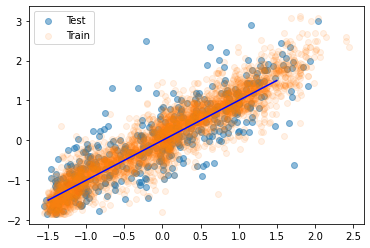

In [98]:
plt.scatter(flatten(y_pred_test), flatten(y_test), alpha=0.5, label="Test")
plt.scatter(flatten(y_pred_train), flatten(y_train), alpha=0.1, label="Train")
plt.legend()
plt.plot([-1.5, 1.5], [-1.5,1.5], c="b")

In [99]:
def predict_smiles(smiles):
    fp =mol2fp(Chem.MolFromSmiles(smiles)).reshape(1,-1)
    fp_filtered = feature_select.transform(fp)
    fp_tensor = torch.tensor(fp_filtered, device=device).float()
    prediction = model(fp_tensor)
    #return prediction.cpu().detach().numpy()
    pXC50 = scaler.inverse_transform(prediction.cpu().detach().numpy())
    return pXC50[0][0]
predict_smiles('Cc1ccc2c(N3CCNCC3)cc(F)cc2n1')

7.6318126

In [100]:
#Different training loop

best_loss = 1000.0

model_folder = "results_QSAR_rdkit"

if not os.path.exists(model_folder):
    os.mkdir(model_folder)

for e in range(epochs):
    print('-' * 10)
    print('Epoch {}/{}'.format(e, epochs - 1))
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()  # Set model to evaluate mode
        
        running_loss = 0
        
        for fps, labels in train_loader:
            # Training pass
            optimizer.zero_grad() #Initialise the gradients, which will be recorded during the forward 

            output = model(fps) #forward pass of the mini-batch
            loss = criterion(output, labels) #computing the loss

            if phase == 'train':
                loss.backward() #calculate the backward pass
                optimizer.step() #optimise the weights

            running_loss += loss.item()
        epoch_loss = running_loss/dataset_sizes[phase]
        print('{} Loss: {:.4f}'.format(phase, epoch_loss))
        
        # deep copy the model
        if phase == 'valid':
            if epoch_loss < best_loss:
                count = 0
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(
                    model.state_dict(),
                    os.path.join(model_folder,
                                 "checkpoint_epoch_{}.pt".format(e)))
                print('saved model checkpoint_epoch_{}.pt'.format(e) + f' into {model_folder}')
            else:
                count += 1

----------
Epoch 0/199
train Loss: 0.0008
valid Loss: 0.0090
saved model checkpoint_epoch_0.pt into results_QSAR_rdkit
----------
Epoch 1/199
train Loss: 0.0008
valid Loss: 0.0086
saved model checkpoint_epoch_1.pt into results_QSAR_rdkit
----------
Epoch 2/199
train Loss: 0.0008
valid Loss: 0.0088
----------
Epoch 3/199
train Loss: 0.0008
valid Loss: 0.0084
saved model checkpoint_epoch_3.pt into results_QSAR_rdkit
----------
Epoch 4/199
train Loss: 0.0008
valid Loss: 0.0088
----------
Epoch 5/199
train Loss: 0.0008
valid Loss: 0.0084
----------
Epoch 6/199
train Loss: 0.0008
valid Loss: 0.0084
----------
Epoch 7/199
train Loss: 0.0008
valid Loss: 0.0088
----------
Epoch 8/199
train Loss: 0.0008
valid Loss: 0.0084
----------
Epoch 9/199
train Loss: 0.0008
valid Loss: 0.0084
----------
Epoch 10/199
train Loss: 0.0008
valid Loss: 0.0084
----------
Epoch 11/199
train Loss: 0.0007
valid Loss: 0.0084
saved model checkpoint_epoch_11.pt into results_QSAR_rdkit
----------
Epoch 12/199
train Los

train Loss: 0.0007
valid Loss: 0.0070
----------
Epoch 105/199
train Loss: 0.0006
valid Loss: 0.0070
----------
Epoch 106/199
train Loss: 0.0006
valid Loss: 0.0071
----------
Epoch 107/199
train Loss: 0.0007
valid Loss: 0.0069
----------
Epoch 108/199
train Loss: 0.0006
valid Loss: 0.0069
saved model checkpoint_epoch_108.pt into results_QSAR_rdkit
----------
Epoch 109/199
train Loss: 0.0007
valid Loss: 0.0072
----------
Epoch 110/199
train Loss: 0.0006
valid Loss: 0.0074
----------
Epoch 111/199
train Loss: 0.0007
valid Loss: 0.0075
----------
Epoch 112/199
train Loss: 0.0007
valid Loss: 0.0076
----------
Epoch 113/199
train Loss: 0.0007
valid Loss: 0.0069
saved model checkpoint_epoch_113.pt into results_QSAR_rdkit
----------
Epoch 114/199
train Loss: 0.0006
valid Loss: 0.0069
saved model checkpoint_epoch_114.pt into results_QSAR_rdkit
----------
Epoch 115/199
train Loss: 0.0006
valid Loss: 0.0068
saved model checkpoint_epoch_115.pt into results_QSAR_rdkit
----------
Epoch 116/199
trai

In [105]:
checkpoint_path = "results_QSAR_rdkit/checkpoint_epoch_11.pt"
model.load_state_dict(torch.load(checkpoint_path), strict=False)

<All keys matched successfully>

In [106]:
def predict_smiles(smiles):
    fp =mol2fp(Chem.MolFromSmiles(smiles)).reshape(1,-1)
    fp_filtered = feature_select.transform(fp)
    fp_tensor = torch.tensor(fp_filtered, device=device).float()
    prediction = model(fp_tensor)
    #return prediction.cpu().detach().numpy()
    pXC50 = scaler.inverse_transform(prediction.cpu().detach().numpy())
    return pXC50[0][0]
predict_smiles('Cc1ccc2c(N3CCNCC3)cc(F)cc2n1')

7.567231